In [1]:
import os
import pandas as pd
import networkx as nx
import pickle
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np
import glob
from tqdm import tqdm
from pathlib import Path
import json
import random


In [2]:
dataset_path = '/datasets/ricordi'

In [3]:
def data_json(dataset_path):
    dataset = []
    # iterate through all folders in the directory
    for folder in glob.glob(dataset_path + '/*'):
        for files in glob.glob(folder + '/*'):
            # check if the file is either a folder or a json file
            if os.path.isdir(files):
                for data_path in glob.glob(files + '/*'):
                    dataset.append(glob.glob(data_path + '/*.json'))
            elif files.endswith('.json'):
                dataset.append(files)
    dataset = list(flatten(dataset))
    print("Total json files:", len(dataset))
    return dataset

In [4]:
def sort_by_key(data,key):
    dataset = []
    for i in data:
        f = open(i)
        json_data = json.load(f)
        if key in json_data:
            dataset.append(i)
        else:
            continue
    print("Json with annotazione1 present:",len(dataset))
    return dataset

In [5]:
dmerge_classes = [[2, 15], [7, 9]]
classes_relevant = [5,6,7,8,9,10,11,12,14,16]
classes_irrelevant = [0,1,2,3,4,15,17]
classes = classes_relevant + classes_irrelevant

# Define the class names in the same order as the classes list
class_names_relevant = [
    "Pause (full or almost)",
    "Single note (with at least the head)",
    "Multiple Notes (with at least the head)",
    "Single chord (with at least heads)",
    "Multiple chords (with at least heads)",
    "Accidental(s) (whole or nearly so)",
    "Key(s) (whole(s) or nearly)",
    "Embellishment(s) (whole(s) or nearly)",
    "More categories (with at least one musical sign)",
    "Other (with at least one musical sign)"
]

class_names_irrelevant = [
    "Page border",
    "Erasure",
    "Blurr",
    "Printed Text",
    "Manuscript Text",
    "More categories (no musical signs)",
    "Other (without musical markings)"
]

# Combine the relevant and irrelevant class names
class_names = class_names_relevant + class_names_irrelevant

In [6]:
json_list = data_json(dataset_path)
sorted_list_by_key = sort_by_key(json_list, "annotazione1")

Total json files: 469590


Json with annotazione1 present: 196639


In [7]:
def plot_distribution_by_class(sorted_list_by_key, classes, key):
    count = {i: 0 for i in classes}
    
    for i in sorted_list_by_key:
        with open(i) as f:
            json_data = json.load(f)
            class_index = json_data[key]
            count[class_index] += 1
    
    print(count)

    # reorder classes, relevant first
    count = [count[i] for i in classes_relevant] + [count[i] for i in classes_irrelevant]
    labels = ["Relevant"] + [None] * (len(classes_relevant) - 1) + ["Irrelevant"] + [None] * (len(classes_irrelevant) - 1)
    colors = ["tab:red" for _ in classes_relevant] + ["tab:blue" for _ in classes_irrelevant]
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.rcParams.update({'font.size': 8})
    plt.bar(x, count, label=labels, color=colors)
    plt.xticks(x, class_names, rotation=45, ha='right')  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.legend()
    plt.show()


{5: 316, 6: 2998, 7: 5621, 8: 975, 9: 818, 10: 2206, 11: 3370, 12: 779, 14: 9039, 16: 1173, 0: 118966, 1: 10370, 2: 13052, 3: 4246, 4: 12501, 15: 1443, 17: 8766}


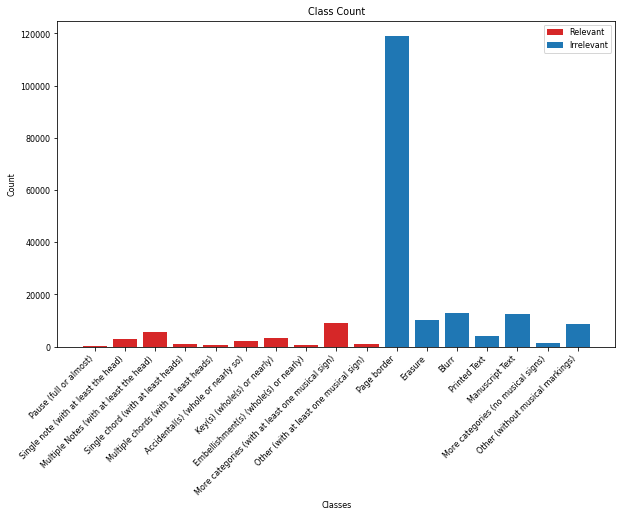

In [8]:
plot_distribution_by_class(sorted_list_by_key,classes, "annotazione1")

In [9]:
from pathlib import Path

binary_dataset_path = Path('binary_dataset')
relevant_path = binary_dataset_path / 'data' / 'relevant'
irrelevant_path = binary_dataset_path / 'data' / 'irrelevant'
relevant_path.mkdir(exist_ok=True, parents=True)
irrelevant_path.mkdir(exist_ok=True, parents=True)

multiclass_dataset_path = Path('multiclass_dataset') / 'data'

In [10]:
from shutil import copyfile

# copy all relevant images to both datasets
for json_file in tqdm(Path(dataset_path).glob("**/*.json")):
    with open(json_file, 'r') as f:
        data = json.load(f)
        if "annotazione1" in data:
            label = int(data["annotazione1"])
            png_path = Path(data["path"][18:])
            # compute the name of the physical copy
            if label in classes_irrelevant:
                copied_path = irrelevant_path / png_path.name
            elif label in classes_relevant:
                copied_path = relevant_path / png_path.name
            else:
                print("Unknown label!")
            # copy the file
            copyfile(dataset_path / png_path, copied_path)
            # symlink into the multiclass dataset
            # N.B. handle merged classes
            if label in [9, 7]:
                class_name = "Multiple notes or chords"
            elif label in [15, 2]:
                class_name = "Blurr or multiple categories (no music signs)"
            else:
                class_name = class_names[classes.index(label)]
            class_path = multiclass_dataset_path / class_name
            class_path.mkdir(exist_ok=True, parents=True)
            (class_path / png_path.name).symlink_to(copied_path)

0it [00:00, ?it/s]

881it [00:00, 8800.00it/s]

1762it [00:00, 7986.08it/s]

2566it [00:00, 5832.67it/s]

3247it [00:00, 6133.77it/s]

3901it [00:00, 6258.07it/s]

4817it [00:00, 7140.30it/s]

5559it [00:00, 7045.70it/s]

6283it [00:00, 6978.50it/s]

7029it [00:01, 7117.87it/s]

7761it [00:01, 7175.12it/s]

8486it [00:01, 6947.53it/s]

9187it [00:01, 6744.63it/s]

9867it [00:01, 6550.65it/s]

10656it [00:01, 6926.12it/s]

11415it [00:01, 7114.71it/s]

12131it [00:01, 6872.41it/s]

12881it [00:01, 7048.72it/s]

13695it [00:01, 7365.07it/s]

14477it [00:02, 7495.71it/s]

15256it [00:02, 7581.48it/s]

16017it [00:02, 7501.16it/s]

16902it [00:02, 7896.73it/s]

17694it [00:02, 7563.49it/s]

18455it [00:02, 7292.98it/s]

19189it [00:02, 7057.00it/s]

20102it [00:02, 7636.71it/s]

20872it [00:02, 7021.89it/s]

21637it [00:03, 7189.72it/s]

22403it [00:03, 7320.89it/s]

23144it [00:03, 7333.55it/s]

23884it [00:03, 7118.88it/s]

24601it [00:03, 7029.37it/s]

25308it [00:03, 6979.60it/s]

26073it [00:03, 7170.95it/s]

26793it [00:03, 6860.05it/s]

27483it [00:03, 6788.61it/s]

28182it [00:03, 6845.46it/s]

28971it [00:04, 7148.80it/s]

29814it [00:04, 7524.31it/s]

30578it [00:04, 7555.43it/s]

31371it [00:04, 7658.85it/s]

32139it [00:04, 6921.64it/s]

32874it [00:04, 7040.29it/s]

33637it [00:04, 7207.43it/s]

34591it [00:04, 7879.65it/s]

35388it [00:04, 7619.33it/s]

36158it [00:05, 7499.70it/s]

36914it [00:05, 7460.23it/s]

37664it [00:05, 7283.61it/s]

38396it [00:05, 7279.36it/s]

39126it [00:05, 7258.31it/s]

39854it [00:05, 6994.85it/s]

40556it [00:05, 6631.53it/s]

41282it [00:05, 6806.64it/s]

41968it [00:05, 6413.90it/s]

42616it [00:06, 5974.15it/s]

43302it [00:06, 6209.89it/s]

44030it [00:06, 6503.79it/s]

44772it [00:06, 6763.64it/s]

45707it [00:06, 7508.15it/s]

46466it [00:06, 6959.39it/s]

47181it [00:06, 7003.40it/s]

47891it [00:06, 6979.46it/s]

48596it [00:06, 5436.77it/s]

49354it [00:07, 5954.20it/s]

50107it [00:07, 6357.25it/s]

50983it [00:07, 7001.20it/s]

51735it [00:07, 7144.07it/s]

52503it [00:07, 7292.48it/s]

53351it [00:07, 7632.96it/s]

54130it [00:07, 7608.14it/s]

54926it [00:07, 7706.63it/s]

55819it [00:07, 8062.70it/s]

56632it [00:07, 7900.95it/s]

57427it [00:08, 7752.88it/s]

58207it [00:08, 7649.13it/s]

58975it [00:08, 7522.67it/s]

59738it [00:08, 7553.61it/s]

60671it [00:08, 8072.58it/s]

61481it [00:08, 7780.00it/s]

62263it [00:08, 7592.29it/s]

63026it [00:08, 7484.70it/s]

63777it [00:08, 7247.31it/s]

64504it [00:09, 7153.28it/s]

65256it [00:09, 7257.18it/s]

65997it [00:09, 7300.49it/s]

66729it [00:09, 7269.79it/s]

67457it [00:09, 7178.60it/s]

68176it [00:09, 7074.51it/s]

69103it [00:09, 7714.41it/s]

69877it [00:09, 7446.16it/s]

70625it [00:09, 7312.98it/s]

71359it [00:10, 6561.77it/s]

72030it [00:10, 6526.85it/s]

72818it [00:10, 6899.54it/s]

73519it [00:10, 6818.30it/s]

74208it [00:10, 6767.20it/s]

74925it [00:10, 6878.44it/s]

75805it [00:10, 7433.35it/s]

76553it [00:10, 7424.98it/s]

77299it [00:10, 6558.96it/s]

77975it [00:11, 5920.10it/s]

78603it [00:11, 6012.28it/s]

79373it [00:11, 6465.38it/s]

80083it [00:11, 6641.31it/s]

80805it [00:11, 6805.02it/s]

81496it [00:11, 6643.58it/s]

82169it [00:11, 6516.24it/s]

82976it [00:11, 6958.73it/s]

83682it [00:11, 6986.69it/s]

84409it [00:11, 7066.23it/s]

85250it [00:12, 7461.04it/s]

86008it [00:12, 7492.42it/s]

86760it [00:12, 7357.90it/s]

87498it [00:12, 7150.01it/s]

88216it [00:12, 7088.12it/s]

88978it [00:12, 7238.22it/s]

89704it [00:12, 7156.48it/s]

90538it [00:12, 7502.54it/s]

91290it [00:12, 7289.86it/s]

92022it [00:12, 7229.85it/s]

92747it [00:13, 7227.89it/s]

93541it [00:13, 7431.29it/s]

94286it [00:13, 7218.20it/s]

95010it [00:13, 5004.73it/s]

95836it [00:13, 5730.31it/s]

96572it [00:13, 6122.18it/s]

97301it [00:13, 6419.42it/s]

98211it [00:13, 7135.92it/s]

98972it [00:14, 6738.69it/s]

99683it [00:14, 6710.14it/s]

100380it [00:14, 6455.87it/s]

101107it [00:14, 6674.49it/s]

101790it [00:14, 6647.54it/s]

102508it [00:14, 6793.85it/s]

103196it [00:14, 6672.07it/s]

104002it [00:14, 7067.84it/s]

104715it [00:14, 6861.31it/s]

105482it [00:15, 7093.07it/s]

106196it [00:15, 5897.44it/s]

106822it [00:15, 4130.28it/s]

107328it [00:15, 3559.11it/s]

107756it [00:15, 3352.16it/s]

108140it [00:15, 3096.06it/s]

108482it [00:16, 2870.45it/s]

108790it [00:16, 2793.35it/s]

109082it [00:16, 2737.46it/s]

109364it [00:16, 2698.62it/s]

109639it [00:16, 2599.85it/s]

109902it [00:16, 2572.11it/s]

110163it [00:16, 2579.87it/s]

110458it [00:16, 2680.56it/s]

110728it [00:17, 2547.09it/s]

111011it [00:17, 2620.13it/s]

111275it [00:17, 2521.54it/s]

111529it [00:17, 2404.22it/s]

111775it [00:17, 2419.20it/s]

112029it [00:17, 2450.44it/s]

112391it [00:17, 2780.86it/s]

112672it [00:17, 2566.15it/s]

112934it [00:17, 2550.83it/s]

113194it [00:17, 2560.27it/s]

113453it [00:18, 2543.71it/s]

113709it [00:18, 2363.69it/s]

114007it [00:18, 2530.73it/s]

114264it [00:18, 2523.87it/s]

114560it [00:18, 2643.46it/s]

114827it [00:18, 2478.18it/s]

115084it [00:18, 2501.55it/s]

115509it [00:18, 2999.35it/s]

115814it [00:18, 2867.50it/s]

116105it [00:19, 2734.17it/s]

116383it [00:19, 2698.13it/s]

116656it [00:19, 2706.01it/s]

116929it [00:19, 2552.96it/s]

117363it [00:19, 3046.29it/s]

117674it [00:19, 2915.23it/s]

117971it [00:19, 2780.87it/s]

118254it [00:19, 2670.28it/s]

118525it [00:19, 2631.76it/s]

118791it [00:20, 2603.78it/s]

119062it [00:20, 2631.06it/s]

119327it [00:20, 2587.30it/s]

119693it [00:20, 2889.66it/s]

119984it [00:20, 2871.10it/s]

120273it [00:20, 2709.41it/s]

120551it [00:20, 2726.19it/s]

120826it [00:20, 2651.55it/s]

121093it [00:20, 2532.81it/s]

121491it [00:21, 2934.25it/s]

121789it [00:21, 2737.87it/s]

122068it [00:21, 2721.97it/s]

122344it [00:21, 2551.22it/s]

122603it [00:21, 2512.12it/s]

122857it [00:21, 2405.88it/s]

123100it [00:21, 2372.16it/s]

123347it [00:21, 2393.31it/s]

123595it [00:21, 2416.03it/s]

123838it [00:22, 2386.22it/s]

124078it [00:22, 2383.83it/s]

124317it [00:22, 2376.55it/s]

124555it [00:22, 2336.29it/s]

124894it [00:22, 2641.80it/s]

125160it [00:22, 2607.92it/s]

125422it [00:22, 2564.75it/s]

125858it [00:22, 3081.18it/s]

126168it [00:22, 2943.77it/s]

126465it [00:22, 2783.64it/s]

126763it [00:23, 2836.87it/s]

127050it [00:23, 2705.36it/s]

127324it [00:23, 2662.78it/s]

127592it [00:23, 2598.59it/s]

127853it [00:23, 2578.52it/s]

128112it [00:23, 2506.15it/s]

128384it [00:23, 2560.64it/s]

128641it [00:23, 2509.28it/s]

128911it [00:23, 2560.83it/s]

129168it [00:24, 2554.38it/s]

129424it [00:24, 2464.62it/s]

129720it [00:24, 2605.12it/s]

130126it [00:24, 3024.34it/s]

130431it [00:24, 2773.24it/s]

130714it [00:24, 2755.30it/s]

130994it [00:24, 2702.30it/s]

131267it [00:24, 2458.16it/s]

131518it [00:24, 2459.54it/s]

131780it [00:25, 2503.46it/s]

132048it [00:25, 2552.38it/s]

132337it [00:25, 2647.24it/s]

132747it [00:25, 3068.77it/s]

133057it [00:25, 2907.01it/s]

133370it [00:25, 2967.19it/s]

133670it [00:25, 2905.07it/s]

133963it [00:25, 2762.38it/s]

134242it [00:25, 2667.53it/s]

134522it [00:26, 2700.02it/s]

134794it [00:26, 2631.72it/s]

135212it [00:26, 3065.19it/s]

135522it [00:26, 2793.50it/s]

135808it [00:26, 2796.63it/s]

136093it [00:26, 2741.52it/s]

136371it [00:26, 2729.50it/s]

136647it [00:26, 2721.78it/s]

136921it [00:26, 2659.40it/s]

137189it [00:26, 2541.72it/s]

137445it [00:27, 2396.88it/s]

137687it [00:27, 2357.01it/s]

137982it [00:27, 2518.95it/s]

138265it [00:27, 2604.54it/s]

138625it [00:27, 2886.80it/s]

139135it [00:27, 3529.52it/s]

139492it [00:27, 3161.62it/s]

139818it [00:27, 2931.01it/s]

140120it [00:28, 2795.76it/s]

140406it [00:28, 2746.95it/s]

140686it [00:28, 2761.03it/s]

140966it [00:28, 2680.21it/s]

141237it [00:28, 2681.98it/s]

141507it [00:28, 1767.22it/s]

141758it [00:28, 1920.52it/s]

141988it [00:28, 2006.98it/s]

142466it [00:29, 2693.53it/s]

142772it [00:29, 2788.49it/s]

143076it [00:29, 2737.37it/s]

143368it [00:29, 2738.65it/s]

143655it [00:29, 2640.13it/s]

143928it [00:29, 2625.14it/s]

144197it [00:29, 2617.07it/s]

144463it [00:29, 2542.89it/s]

144781it [00:29, 2716.80it/s]

145056it [00:29, 2674.80it/s]

145326it [00:30, 2662.55it/s]

145728it [00:30, 3053.69it/s]

146037it [00:30, 2983.33it/s]

146338it [00:30, 2909.98it/s]

146631it [00:30, 2858.75it/s]

146919it [00:30, 2747.70it/s]

147196it [00:30, 2721.49it/s]

147470it [00:30, 2680.42it/s]

147739it [00:30, 2624.72it/s]

148002it [00:31, 2556.26it/s]

148593it [00:31, 3507.23it/s]

148950it [00:31, 3243.38it/s]

149282it [00:31, 3030.23it/s]

149592it [00:31, 2975.20it/s]

149895it [00:31, 2762.63it/s]

150181it [00:31, 2785.88it/s]

150464it [00:31, 2723.47it/s]

150739it [00:31, 2644.41it/s]

151013it [00:32, 2667.02it/s]

151282it [00:32, 2648.78it/s]

151548it [00:32, 2585.11it/s]

151840it [00:32, 2674.90it/s]

152109it [00:32, 2664.42it/s]

152377it [00:32, 2534.05it/s]

152632it [00:32, 2440.99it/s]

152887it [00:32, 2468.25it/s]

153162it [00:32, 2543.74it/s]

153422it [00:33, 2552.97it/s]

153692it [00:33, 2588.43it/s]

153952it [00:33, 2547.87it/s]

154208it [00:33, 2534.97it/s]

154462it [00:33, 2474.91it/s]

154870it [00:33, 2935.95it/s]

155166it [00:33, 2838.80it/s]

155452it [00:33, 2825.94it/s]

155736it [00:33, 2816.72it/s]

156019it [00:33, 2699.11it/s]

156291it [00:34, 2697.88it/s]

156562it [00:34, 2698.47it/s]

156837it [00:34, 2710.56it/s]

157111it [00:34, 2713.53it/s]

157526it [00:34, 3134.78it/s]

157841it [00:34, 2965.34it/s]

158140it [00:34, 2878.01it/s]

158430it [00:34, 2611.53it/s]

158697it [00:34, 2511.88it/s]

158952it [00:35, 2479.79it/s]

159220it [00:35, 2529.43it/s]

159476it [00:35, 2513.90it/s]

159729it [00:35, 2503.00it/s]

159981it [00:35, 2474.07it/s]

160266it [00:35, 2581.69it/s]

160526it [00:35, 2505.66it/s]

160959it [00:35, 3023.44it/s]

161264it [00:35, 2766.85it/s]

161547it [00:36, 2697.63it/s]

161845it [00:36, 2769.94it/s]

162143it [00:36, 2822.89it/s]

162428it [00:36, 2830.33it/s]

162713it [00:36, 2689.53it/s]

162993it [00:36, 2717.85it/s]

163267it [00:36, 2634.94it/s]

163533it [00:36, 2596.15it/s]

163794it [00:36, 2504.05it/s]

164046it [00:37, 2496.26it/s]

164297it [00:37, 2498.59it/s]

164555it [00:37, 2516.95it/s]

164808it [00:37, 2452.08it/s]

165089it [00:37, 2555.24it/s]

165381it [00:37, 2661.59it/s]

165938it [00:37, 3510.43it/s]

166291it [00:37, 3182.60it/s]

166617it [00:37, 2903.23it/s]

166916it [00:38, 2749.07it/s]

167198it [00:38, 2738.97it/s]

167477it [00:38, 2520.20it/s]

167735it [00:38, 2439.44it/s]

167983it [00:38, 2438.28it/s]

168259it [00:38, 2512.28it/s]

168513it [00:38, 2367.50it/s]

168784it [00:38, 2459.98it/s]

169036it [00:38, 2474.85it/s]

169304it [00:38, 2531.72it/s]

169559it [00:39, 2506.58it/s]

169814it [00:39, 2516.99it/s]

170090it [00:39, 2584.27it/s]

170350it [00:39, 2445.18it/s]

170602it [00:39, 2464.89it/s]

170850it [00:39, 2384.30it/s]

171092it [00:39, 2389.32it/s]

171332it [00:39, 2353.09it/s]

171853it [00:39, 3156.20it/s]

172171it [00:40, 2774.76it/s]

172458it [00:40, 2600.69it/s]

172726it [00:40, 2539.89it/s]

172987it [00:40, 2554.94it/s]

173252it [00:40, 2577.65it/s]

173513it [00:40, 2511.60it/s]

173767it [00:40, 2480.24it/s]

174034it [00:40, 2527.61it/s]

174297it [00:40, 2553.92it/s]

174554it [00:41, 2519.17it/s]

174807it [00:41, 2492.31it/s]

175057it [00:41, 2439.85it/s]

175302it [00:41, 2390.72it/s]

175542it [00:41, 2381.10it/s]

175782it [00:41, 2385.61it/s]

176036it [00:41, 2428.08it/s]

176304it [00:41, 2502.06it/s]

176758it [00:41, 3103.49it/s]

177070it [00:42, 2832.66it/s]

177368it [00:42, 2870.36it/s]

177659it [00:42, 2782.44it/s]

177941it [00:42, 2722.36it/s]

178216it [00:42, 2667.44it/s]

178490it [00:42, 2687.73it/s]

178760it [00:42, 2653.36it/s]

179027it [00:42, 2588.09it/s]

179287it [00:42, 2576.50it/s]

179546it [00:42, 2490.17it/s]

179796it [00:43, 2392.58it/s]

180037it [00:43, 2395.83it/s]

180278it [00:43, 2375.76it/s]

180642it [00:43, 2735.13it/s]

180918it [00:43, 2657.76it/s]

181186it [00:43, 2656.47it/s]

181453it [00:43, 2571.06it/s]

181715it [00:43, 2581.93it/s]

181975it [00:43, 2524.26it/s]

182229it [00:44, 2516.87it/s]

182482it [00:44, 2487.81it/s]

182830it [00:44, 2775.92it/s]

183109it [00:44, 2644.45it/s]

183377it [00:44, 2653.87it/s]

183647it [00:44, 2661.66it/s]

183942it [00:44, 2743.70it/s]

184218it [00:44, 2669.43it/s]

184507it [00:44, 2730.38it/s]

184781it [00:44, 2581.08it/s]

185042it [00:45, 2450.45it/s]

185290it [00:45, 2430.61it/s]

185535it [00:45, 2364.01it/s]

185789it [00:45, 2408.25it/s]

186031it [00:45, 2359.78it/s]

186467it [00:45, 2928.83it/s]

186764it [00:45, 2798.12it/s]

187048it [00:45, 2748.12it/s]

187326it [00:45, 2671.32it/s]

187595it [00:46, 2595.23it/s]

187856it [00:46, 2577.93it/s]

188115it [00:46, 2500.92it/s]

188366it [00:46, 2466.28it/s]

188615it [00:46, 2469.29it/s]

188893it [00:46, 2554.67it/s]

189149it [00:46, 2497.97it/s]

189400it [00:46, 2462.93it/s]

189824it [00:46, 2972.12it/s]

190124it [00:47, 2777.06it/s]

190406it [00:47, 2648.67it/s]

190690it [00:47, 2698.85it/s]

190963it [00:47, 2620.67it/s]

191228it [00:47, 2539.95it/s]

191513it [00:47, 2623.94it/s]

191778it [00:47, 2565.24it/s]

192036it [00:47, 2514.80it/s]

192289it [00:47, 2496.82it/s]

192559it [00:47, 2554.92it/s]

192821it [00:48, 2572.78it/s]

193115it [00:48, 2679.25it/s]

193384it [00:48, 2593.26it/s]

193852it [00:48, 3197.16it/s]

194175it [00:48, 3145.41it/s]

194492it [00:48, 2950.36it/s]

194791it [00:48, 2903.71it/s]

195084it [00:48, 2839.89it/s]

195370it [00:48, 2813.87it/s]

195653it [00:49, 2744.46it/s]

195929it [00:49, 2665.37it/s]

196197it [00:49, 1683.48it/s]

196497it [00:49, 1947.44it/s]

196769it [00:49, 2117.19it/s]

197047it [00:49, 2277.66it/s]

197310it [00:49, 2366.70it/s]

197569it [00:49, 2348.16it/s]

197820it [00:50, 2281.38it/s]

198059it [00:50, 2257.32it/s]

198309it [00:50, 2323.03it/s]

198703it [00:50, 2775.23it/s]

198988it [00:50, 2685.04it/s]

199267it [00:50, 2709.16it/s]

199542it [00:50, 2696.68it/s]

199822it [00:50, 2725.97it/s]

200106it [00:50, 2758.59it/s]

200384it [00:51, 2646.34it/s]

200651it [00:51, 2642.74it/s]

201168it [00:51, 3374.61it/s]

201509it [00:51, 3097.59it/s]

201826it [00:51, 2873.79it/s]

202121it [00:51, 2649.38it/s]

202393it [00:51, 2615.50it/s]

202659it [00:51, 2439.98it/s]

202937it [00:51, 2524.93it/s]

203194it [00:52, 2396.40it/s]

203679it [00:52, 3053.04it/s]

203995it [00:52, 2862.43it/s]

204290it [00:52, 2864.75it/s]

204583it [00:52, 2809.04it/s]

204876it [00:52, 2836.81it/s]

205163it [00:52, 2751.23it/s]

205441it [00:52, 2691.22it/s]

205712it [00:52, 2558.13it/s]

205970it [00:53, 2479.97it/s]

206305it [00:53, 2719.03it/s]

206580it [00:53, 2660.60it/s]

206849it [00:53, 2621.22it/s]

207116it [00:53, 2630.23it/s]

207381it [00:53, 2566.22it/s]

207648it [00:53, 2594.91it/s]

207909it [00:53, 2451.04it/s]

208156it [00:53, 2438.73it/s]

208425it [00:54, 2509.75it/s]

208873it [00:54, 3078.39it/s]

209184it [00:54, 2962.72it/s]

209486it [00:54, 2973.67it/s]

209788it [00:54, 2985.09it/s]

210088it [00:54, 2849.95it/s]

210376it [00:54, 2783.63it/s]

210656it [00:54, 2735.79it/s]

210931it [00:54, 2717.85it/s]

211204it [00:55, 2583.15it/s]

211586it [00:55, 2929.99it/s]

211883it [00:55, 2855.20it/s]

212172it [00:55, 2775.24it/s]

212452it [00:55, 2665.68it/s]

212721it [00:55, 2623.65it/s]

213276it [00:55, 3443.60it/s]

213627it [00:55, 3154.68it/s]

213951it [00:55, 2925.68it/s]

214252it [00:56, 2851.02it/s]

214543it [00:56, 2686.77it/s]

214817it [00:56, 2676.44it/s]

215089it [00:56, 2687.30it/s]

215374it [00:56, 2731.42it/s]

215649it [00:56, 2708.62it/s]

215922it [00:56, 2697.82it/s]

216193it [00:56, 2673.23it/s]

216461it [00:56, 2521.94it/s]

216716it [00:57, 2506.94it/s]

217219it [00:57, 3225.13it/s]

217547it [00:57, 2941.07it/s]

217849it [00:57, 2833.67it/s]

218138it [00:57, 2761.19it/s]

218418it [00:57, 2743.00it/s]

218695it [00:57, 2668.64it/s]

218964it [00:57, 2605.09it/s]

219230it [00:57, 2616.76it/s]

219493it [00:58, 2541.17it/s]

219748it [00:58, 2400.39it/s]

220015it [00:58, 2470.88it/s]

220264it [00:58, 2472.63it/s]

220772it [00:58, 3218.36it/s]

221098it [00:58, 3014.43it/s]

221405it [00:58, 2873.99it/s]

221697it [00:58, 2637.38it/s]

221967it [00:58, 2612.31it/s]

222232it [00:59, 2598.88it/s]

222495it [00:59, 2573.82it/s]

222763it [00:59, 2602.32it/s]

223025it [00:59, 2595.62it/s]

223286it [00:59, 2583.40it/s]

223587it [00:59, 2702.03it/s]

223963it [00:59, 3012.09it/s]

224266it [00:59, 2786.08it/s]

224549it [00:59, 2655.49it/s]

224819it [01:00, 2471.53it/s]

225071it [01:00, 2477.67it/s]

225322it [01:00, 2458.01it/s]

225646it [01:00, 2671.12it/s]

225916it [01:00, 2669.67it/s]

226188it [01:00, 2680.17it/s]

226458it [01:00, 2520.11it/s]

226713it [01:00, 2431.50it/s]

227063it [01:00, 2723.45it/s]

227339it [01:00, 2580.52it/s]

227601it [01:01, 2535.08it/s]

227857it [01:01, 2534.84it/s]

228124it [01:01, 2571.06it/s]

228544it [01:01, 3040.76it/s]

228851it [01:01, 3022.05it/s]

229156it [01:01, 2604.92it/s]

229428it [01:01, 2462.46it/s]

229683it [01:01, 2300.14it/s]

229944it [01:01, 2378.67it/s]

230200it [01:02, 2425.47it/s]

230494it [01:02, 2567.29it/s]

230775it [01:02, 2632.87it/s]

231042it [01:02, 2602.69it/s]

231305it [01:02, 2552.06it/s]

231577it [01:02, 2597.63it/s]

231950it [01:02, 2918.96it/s]

232244it [01:02, 2729.21it/s]

232521it [01:02, 2610.55it/s]

232812it [01:03, 2691.32it/s]

233084it [01:03, 2613.89it/s]

233348it [01:03, 2551.98it/s]

233626it [01:03, 2614.74it/s]

233889it [01:03, 2606.39it/s]

234151it [01:03, 2476.16it/s]

234417it [01:03, 2525.66it/s]

234686it [01:03, 2570.38it/s]

234982it [01:03, 2680.94it/s]

235335it [01:03, 2928.48it/s]

235630it [01:04, 2806.23it/s]

235913it [01:04, 2659.54it/s]

236182it [01:04, 2518.32it/s]

236440it [01:04, 2532.74it/s]

236696it [01:04, 2450.10it/s]

236948it [01:04, 2464.74it/s]

237207it [01:04, 2496.03it/s]

237458it [01:04, 2428.93it/s]

237724it [01:04, 2489.16it/s]

238001it [01:05, 2568.34it/s]

238394it [01:05, 2958.89it/s]

238692it [01:05, 2767.22it/s]

238972it [01:05, 2508.47it/s]

239268it [01:05, 2624.96it/s]

239553it [01:05, 2683.82it/s]

239826it [01:05, 2661.03it/s]

240096it [01:05, 2671.22it/s]

240366it [01:05, 2619.00it/s]

240774it [01:06, 3032.17it/s]

241080it [01:06, 2785.80it/s]

241364it [01:06, 2732.21it/s]

241641it [01:06, 2604.55it/s]

241905it [01:06, 2607.46it/s]

242200it [01:06, 2697.99it/s]

242474it [01:06, 2703.27it/s]

242746it [01:06, 2664.46it/s]

243109it [01:06, 2943.20it/s]

243406it [01:07, 2659.92it/s]

243679it [01:07, 2487.40it/s]

243937it [01:07, 2506.70it/s]

244192it [01:07, 2507.69it/s]

244446it [01:07, 2471.60it/s]

244713it [01:07, 2526.53it/s]

244968it [01:07, 2483.46it/s]

245252it [01:07, 2580.25it/s]

245908it [01:07, 3731.92it/s]

246286it [01:08, 3436.78it/s]

246637it [01:08, 3063.70it/s]

246955it [01:08, 2905.81it/s]

247254it [01:08, 2784.71it/s]

247538it [01:08, 2767.74it/s]

247819it [01:08, 2713.31it/s]

248093it [01:08, 2672.05it/s]

248362it [01:08, 2674.25it/s]

248631it [01:08, 2660.36it/s]

248898it [01:09, 2644.19it/s]

249173it [01:09, 2673.64it/s]

249441it [01:09, 2575.48it/s]

249733it [01:09, 2671.40it/s]

250005it [01:09, 2679.08it/s]

250276it [01:09, 2683.58it/s]

250714it [01:09, 3177.51it/s]

251033it [01:09, 2950.47it/s]

251332it [01:09, 2893.30it/s]

251624it [01:10, 2854.58it/s]

251912it [01:10, 2675.14it/s]

252183it [01:10, 2520.12it/s]

252448it [01:10, 2551.27it/s]

252707it [01:10, 2561.61it/s]

252968it [01:10, 2571.20it/s]

253227it [01:10, 2365.10it/s]

253468it [01:10, 2248.46it/s]

253716it [01:10, 2306.90it/s]

253983it [01:11, 2407.15it/s]

254243it [01:11, 2459.62it/s]

254518it [01:11, 2539.40it/s]

254940it [01:11, 3024.96it/s]

255245it [01:11, 2807.98it/s]

255531it [01:11, 2750.34it/s]

255810it [01:11, 2708.13it/s]

256083it [01:11, 2575.92it/s]

256343it [01:11, 2527.47it/s]

256599it [01:11, 2533.86it/s]

256863it [01:12, 2563.73it/s]

257140it [01:12, 2618.48it/s]

257403it [01:12, 2603.22it/s]

257682it [01:12, 2655.63it/s]

257949it [01:12, 2606.06it/s]

258267it [01:12, 2767.01it/s]

258545it [01:12, 2766.30it/s]

258906it [01:12, 3013.43it/s]

259209it [01:12, 2841.03it/s]

259496it [01:13, 2757.26it/s]

259774it [01:13, 2752.68it/s]

260176it [01:13, 3114.56it/s]

260490it [01:13, 2876.30it/s]

260783it [01:13, 2619.26it/s]

261052it [01:13, 2612.45it/s]

261318it [01:13, 2600.90it/s]

261582it [01:13, 2564.65it/s]

261841it [01:13, 2490.61it/s]

262113it [01:14, 2553.03it/s]

262385it [01:14, 2597.60it/s]

262685it [01:14, 2711.25it/s]

262958it [01:14, 2652.68it/s]

263226it [01:14, 2657.58it/s]

263493it [01:14, 2523.91it/s]

263883it [01:14, 2908.99it/s]

264178it [01:14, 2761.91it/s]

264458it [01:14, 2696.17it/s]

264731it [01:15, 2592.50it/s]

264994it [01:15, 2602.80it/s]

265256it [01:15, 2603.23it/s]

265518it [01:15, 2577.04it/s]

265787it [01:15, 2609.66it/s]

266049it [01:15, 2598.80it/s]

266324it [01:15, 2640.82it/s]

266602it [01:15, 2679.33it/s]

266871it [01:15, 2508.36it/s]

267125it [01:15, 2516.69it/s]

267598it [01:16, 1826.75it/s]

267816it [01:16, 1881.13it/s]

268086it [01:16, 2055.48it/s]

268352it [01:16, 2193.72it/s]

268596it [01:16, 2252.88it/s]

268838it [01:16, 2205.18it/s]

269070it [01:16, 2209.88it/s]

269320it [01:17, 2282.52it/s]

269568it [01:17, 2334.71it/s]

269807it [01:17, 2285.39it/s]

270049it [01:17, 2321.83it/s]

270312it [01:17, 2408.93it/s]

270566it [01:17, 2444.69it/s]

270815it [01:17, 2452.48it/s]

271068it [01:17, 2469.24it/s]

271577it [01:17, 3237.69it/s]

271902it [01:17, 3099.61it/s]

272214it [01:18, 2856.48it/s]

272505it [01:18, 2722.17it/s]

272781it [01:18, 2705.60it/s]

273055it [01:18, 2592.18it/s]

273322it [01:18, 2611.24it/s]

273605it [01:18, 2667.85it/s]

273874it [01:18, 2637.10it/s]

274256it [01:18, 2971.86it/s]

274556it [01:18, 2829.76it/s]

274842it [01:19, 2706.11it/s]

275116it [01:19, 2652.56it/s]

275519it [01:19, 3032.14it/s]

275826it [01:19, 2919.33it/s]

276122it [01:19, 2747.79it/s]

276401it [01:19, 2689.50it/s]

276673it [01:19, 2495.49it/s]

276944it [01:19, 2550.10it/s]

277203it [01:19, 2473.27it/s]

277465it [01:20, 2509.16it/s]

277882it [01:20, 2977.45it/s]

278184it [01:20, 2719.81it/s]

278463it [01:20, 2625.25it/s]

278731it [01:20, 2606.18it/s]

278995it [01:20, 2579.84it/s]

279270it [01:20, 2624.95it/s]

279535it [01:20, 2593.60it/s]

280053it [01:20, 3333.64it/s]

280391it [01:21, 3149.67it/s]

280711it [01:21, 2916.00it/s]

281009it [01:21, 2906.92it/s]

281304it [01:21, 2775.36it/s]

281585it [01:21, 2645.80it/s]

281853it [01:21, 2438.24it/s]

282101it [01:21, 2377.44it/s]

282372it [01:21, 2465.94it/s]

282626it [01:21, 2483.57it/s]

282877it [01:22, 2432.12it/s]

283122it [01:22, 2409.60it/s]

283364it [01:22, 2386.81it/s]

283606it [01:22, 2396.32it/s]

283851it [01:22, 2407.67it/s]

284111it [01:22, 2460.82it/s]

284358it [01:22, 2434.09it/s]

284739it [01:22, 2835.37it/s]

285024it [01:22, 2718.39it/s]

285298it [01:23, 2611.20it/s]

285561it [01:23, 2574.18it/s]

285820it [01:23, 2555.33it/s]

286077it [01:23, 2533.83it/s]

286598it [01:23, 3298.96it/s]

286931it [01:23, 3074.24it/s]

287244it [01:23, 2953.49it/s]

287544it [01:23, 2778.30it/s]

287826it [01:23, 2567.61it/s]

288088it [01:24, 2570.62it/s]

288349it [01:24, 2552.81it/s]

288607it [01:24, 2539.59it/s]

288863it [01:24, 2421.31it/s]

289132it [01:24, 2492.09it/s]

289383it [01:24, 2492.26it/s]

289643it [01:24, 2518.04it/s]

289896it [01:24, 2464.97it/s]

290144it [01:24, 2359.32it/s]

290716it [01:24, 3302.13it/s]

291053it [01:25, 3120.44it/s]

291371it [01:25, 2837.18it/s]

291663it [01:25, 2719.56it/s]

291941it [01:25, 2624.88it/s]

292208it [01:25, 2586.79it/s]

292483it [01:25, 2630.92it/s]

292749it [01:25, 2544.74it/s]

293036it [01:25, 2635.08it/s]

293302it [01:26, 2552.65it/s]

293578it [01:26, 2605.28it/s]

293844it [01:26, 2614.81it/s]

294107it [01:26, 2445.11it/s]

294359it [01:26, 2464.21it/s]

294611it [01:26, 2475.15it/s]

294882it [01:26, 2542.74it/s]

295138it [01:26, 2535.83it/s]

295393it [01:26, 2530.73it/s]

295647it [01:26, 2494.97it/s]

295913it [01:27, 2537.50it/s]

296450it [01:27, 3366.83it/s]

296789it [01:27, 3141.00it/s]

297108it [01:27, 2933.65it/s]

297407it [01:27, 2790.11it/s]

297690it [01:27, 2633.96it/s]

297969it [01:27, 2674.36it/s]

298240it [01:27, 2600.43it/s]

298529it [01:27, 2675.75it/s]

298799it [01:28, 2676.23it/s]

299078it [01:28, 2704.96it/s]

299364it [01:28, 2749.87it/s]

299640it [01:28, 2750.68it/s]

299916it [01:28, 2673.62it/s]

300192it [01:28, 2692.33it/s]

300463it [01:28, 2693.39it/s]

300932it [01:28, 3280.89it/s]

301262it [01:28, 3019.51it/s]

301569it [01:28, 2988.64it/s]

301872it [01:29, 2976.91it/s]

302172it [01:29, 2868.11it/s]

302461it [01:29, 2778.40it/s]

302741it [01:29, 2709.28it/s]

303014it [01:29, 2665.54it/s]

303282it [01:29, 2596.11it/s]

303543it [01:29, 2463.62it/s]

303791it [01:29, 2446.54it/s]

304038it [01:29, 2450.26it/s]

304284it [01:30, 2441.73it/s]

304675it [01:30, 2864.58it/s]

304964it [01:30, 2533.94it/s]

305226it [01:30, 2535.41it/s]

305506it [01:30, 2607.15it/s]

305777it [01:30, 2631.15it/s]

306048it [01:30, 2649.93it/s]

306316it [01:30, 2523.11it/s]

306616it [01:30, 2657.81it/s]

306885it [01:31, 2649.20it/s]

307152it [01:31, 2557.72it/s]

307410it [01:31, 2542.52it/s]

307666it [01:31, 2509.01it/s]

307970it [01:31, 2660.13it/s]

308373it [01:31, 3057.90it/s]

308681it [01:31, 2957.16it/s]

308979it [01:31, 2919.81it/s]

309273it [01:31, 2864.92it/s]

309561it [01:32, 2834.65it/s]

309846it [01:32, 2791.26it/s]

310126it [01:32, 2641.72it/s]

310405it [01:32, 2680.74it/s]

310675it [01:32, 2666.92it/s]

310966it [01:32, 2734.12it/s]

311382it [01:32, 3148.29it/s]

311699it [01:32, 2963.73it/s]

311999it [01:32, 2817.66it/s]

312284it [01:32, 2704.36it/s]

312557it [01:33, 2602.90it/s]

312820it [01:33, 2557.73it/s]

313086it [01:33, 2580.43it/s]

313351it [01:33, 2598.08it/s]

313737it [01:33, 2960.26it/s]

314069it [01:33, 3060.61it/s]

314400it [01:33, 3133.72it/s]

314715it [01:33, 3092.10it/s]

315056it [01:33, 3178.50it/s]

315377it [01:34, 3185.23it/s]

315709it [01:34, 3224.60it/s]

316073it [01:34, 3346.38it/s]

316412it [01:34, 3358.96it/s]

316927it [01:34, 3884.07it/s]

317316it [01:34, 3442.68it/s]

317670it [01:34, 3105.16it/s]

317992it [01:34, 2969.87it/s]

318297it [01:34, 2840.55it/s]

318587it [01:35, 2748.42it/s]

318866it [01:35, 2551.60it/s]

319125it [01:35, 2561.07it/s]

319384it [01:35, 2486.70it/s]

319635it [01:35, 2453.23it/s]

319916it [01:35, 2547.35it/s]

320201it [01:35, 2632.20it/s]

320466it [01:35, 2624.46it/s]

320730it [01:35, 2552.44it/s]

321004it [01:36, 2601.50it/s]

321278it [01:36, 2639.57it/s]

321543it [01:36, 2590.34it/s]

321803it [01:36, 2585.59it/s]

322084it [01:36, 2644.85it/s]

322349it [01:36, 2513.56it/s]

322602it [01:36, 2501.98it/s]

322981it [01:36, 2867.79it/s]

323270it [01:36, 2629.60it/s]

323538it [01:36, 2578.60it/s]

323800it [01:37, 2480.57it/s]

324051it [01:37, 2395.69it/s]

324308it [01:37, 2441.48it/s]

324554it [01:37, 2437.84it/s]

324810it [01:37, 2469.93it/s]

325087it [01:37, 2554.18it/s]

325578it [01:37, 3238.40it/s]

325904it [01:37, 2974.13it/s]

326207it [01:37, 2978.12it/s]

326509it [01:38, 2913.59it/s]

326804it [01:38, 2855.24it/s]

327092it [01:38, 2808.93it/s]

327383it [01:38, 2835.41it/s]

327668it [01:38, 2692.17it/s]

327940it [01:38, 2571.07it/s]

328206it [01:38, 2590.65it/s]

328479it [01:38, 2627.04it/s]

328743it [01:38, 2522.84it/s]

329017it [01:39, 2583.46it/s]

329277it [01:39, 2481.44it/s]

329557it [01:39, 2566.71it/s]

329833it [01:39, 2615.68it/s]

330096it [01:39, 2578.14it/s]

330365it [01:39, 2603.66it/s]

330627it [01:39, 2566.37it/s]

330905it [01:39, 2628.33it/s]

331169it [01:39, 2628.01it/s]

331433it [01:39, 2560.08it/s]

331691it [01:40, 2563.71it/s]

331975it [01:40, 2640.61it/s]

332240it [01:40, 2477.59it/s]

332497it [01:40, 2499.78it/s]

332749it [01:40, 2438.49it/s]

333006it [01:40, 2475.90it/s]

333282it [01:40, 2554.59it/s]

333544it [01:40, 2571.63it/s]

333820it [01:40, 2626.27it/s]

334084it [01:41, 2578.46it/s]

334425it [01:41, 2815.96it/s]

334708it [01:41, 2726.02it/s]

334982it [01:41, 2625.30it/s]

335246it [01:41, 2598.81it/s]

335507it [01:41, 2595.74it/s]

335768it [01:41, 2485.30it/s]

336039it [01:41, 2545.29it/s]

336295it [01:41, 2526.11it/s]

336549it [01:41, 2445.45it/s]

336795it [01:42, 2378.95it/s]

337721it [01:42, 4321.74it/s]

338164it [01:42, 3477.92it/s]

338545it [01:42, 3204.22it/s]

338891it [01:42, 2998.68it/s]

339209it [01:42, 2890.41it/s]

339510it [01:42, 2831.17it/s]

339801it [01:43, 2678.11it/s]

340074it [01:43, 2686.24it/s]

340347it [01:43, 2660.90it/s]

340621it [01:43, 2678.17it/s]

340891it [01:43, 2676.25it/s]

341168it [01:43, 2702.03it/s]

341440it [01:43, 2598.25it/s]

341711it [01:43, 2626.62it/s]

342018it [01:43, 2753.43it/s]

342295it [01:43, 2567.74it/s]

342635it [01:44, 2800.25it/s]

342978it [01:44, 2979.46it/s]

343280it [01:44, 2785.53it/s]

343566it [01:44, 2802.31it/s]

343850it [01:44, 2725.90it/s]

344126it [01:44, 2679.74it/s]

344396it [01:44, 2674.78it/s]

344675it [01:44, 2700.53it/s]

344952it [01:44, 2719.94it/s]

345225it [01:45, 2685.93it/s]

345495it [01:45, 2597.06it/s]

345761it [01:45, 2614.40it/s]

346024it [01:45, 2574.06it/s]

346282it [01:45, 2549.37it/s]

346542it [01:45, 2558.17it/s]

346826it [01:45, 2635.47it/s]

347091it [01:45, 2637.98it/s]

347365it [01:45, 2663.93it/s]

347649it [01:45, 2710.44it/s]

347947it [01:46, 2786.46it/s]

348226it [01:46, 2628.33it/s]

348491it [01:46, 2592.91it/s]

348752it [01:46, 2395.67it/s]

348995it [01:46, 2283.64it/s]

349298it [01:46, 2485.65it/s]

349560it [01:46, 2516.87it/s]

349815it [01:46, 2435.45it/s]

350061it [01:46, 2430.48it/s]

350360it [01:47, 2584.47it/s]

350621it [01:47, 2510.07it/s]

350921it [01:47, 2649.79it/s]

351188it [01:47, 2425.48it/s]

351436it [01:47, 2301.11it/s]

351684it [01:47, 2342.80it/s]

351934it [01:47, 2380.94it/s]

352175it [01:47, 2317.65it/s]

352450it [01:47, 2438.93it/s]

352738it [01:48, 2561.41it/s]

353071it [01:48, 2779.05it/s]

353351it [01:48, 2745.15it/s]

353627it [01:48, 2627.19it/s]

353892it [01:48, 2544.61it/s]

354150it [01:48, 2549.10it/s]

354419it [01:48, 2583.93it/s]

354679it [01:48, 2557.62it/s]

355153it [01:48, 3188.85it/s]

355475it [01:48, 2942.14it/s]

355775it [01:49, 2923.52it/s]

356071it [01:49, 1532.35it/s]

356312it [01:49, 1683.38it/s]

356575it [01:49, 1870.71it/s]

356829it [01:49, 2015.53it/s]

357074it [01:49, 2113.91it/s]

357318it [01:50, 2184.31it/s]

357561it [01:50, 2206.82it/s]

357803it [01:50, 2261.54it/s]

358042it [01:50, 2220.39it/s]

358273it [01:50, 2244.21it/s]

358504it [01:50, 2262.38it/s]

358761it [01:50, 2349.93it/s]

359016it [01:50, 2402.48it/s]

359280it [01:50, 2467.12it/s]

359541it [01:50, 2502.50it/s]

359815it [01:51, 2566.88it/s]

360073it [01:51, 2525.07it/s]

360327it [01:51, 2527.15it/s]

360581it [01:51, 2530.62it/s]

361166it [01:51, 3512.06it/s]

361519it [01:51, 3212.13it/s]

361846it [01:51, 3118.23it/s]

362162it [01:51, 2941.99it/s]

362461it [01:51, 2753.39it/s]

362741it [01:52, 2713.44it/s]

363015it [01:52, 2687.27it/s]

363286it [01:52, 2633.18it/s]

363551it [01:52, 2552.25it/s]

363822it [01:52, 2590.84it/s]

364085it [01:52, 2597.95it/s]

364346it [01:52, 2557.96it/s]

364603it [01:52, 2492.56it/s]

364884it [01:52, 2583.09it/s]

365144it [01:52, 2567.35it/s]

365402it [01:53, 2556.96it/s]

365659it [01:53, 2517.46it/s]

365932it [01:53, 2577.60it/s]

366191it [01:53, 2564.47it/s]

366448it [01:53, 2520.07it/s]

366734it [01:53, 2614.43it/s]

367027it [01:53, 2705.92it/s]

367316it [01:53, 2754.42it/s]

367596it [01:53, 2765.64it/s]

367873it [01:54, 2708.70it/s]

368145it [01:54, 2644.23it/s]

368410it [01:54, 2569.78it/s]

368679it [01:54, 2600.84it/s]

368940it [01:54, 2562.24it/s]

369223it [01:54, 2634.68it/s]

369487it [01:54, 2585.59it/s]

369750it [01:54, 2598.31it/s]

370011it [01:54, 2601.44it/s]

370272it [01:54, 2460.91it/s]

370520it [01:55, 2420.64it/s]

371025it [01:55, 3168.42it/s]

371347it [01:55, 2918.49it/s]

371646it [01:55, 2747.48it/s]

371927it [01:55, 2682.53it/s]

372200it [01:55, 2540.23it/s]

372458it [01:55, 2516.53it/s]

372712it [01:55, 2479.39it/s]

372967it [01:55, 2496.51it/s]

373218it [01:56, 2472.46it/s]

373485it [01:56, 2528.65it/s]

373759it [01:56, 2588.35it/s]

374022it [01:56, 2596.36it/s]

374291it [01:56, 2623.46it/s]

374554it [01:56, 2528.59it/s]

374808it [01:56, 2513.42it/s]

375060it [01:56, 2394.60it/s]

375315it [01:56, 2437.98it/s]

375582it [01:57, 2501.97it/s]

375834it [01:57, 2413.20it/s]

376081it [01:57, 2425.93it/s]

376325it [01:57, 2379.78it/s]

376564it [01:57, 2356.22it/s]

376801it [01:57, 2356.55it/s]

377037it [01:57, 2330.02it/s]

377322it [01:57, 2479.25it/s]

377580it [01:57, 2508.25it/s]

377866it [01:57, 2612.17it/s]

378159it [01:58, 2702.36it/s]

378430it [01:58, 2675.10it/s]

378768it [01:58, 2877.77it/s]

379057it [01:58, 2829.67it/s]

379341it [01:58, 2730.50it/s]

379616it [01:58, 2731.41it/s]

379890it [01:58, 2556.85it/s]

380149it [01:58, 2550.10it/s]

380406it [01:58, 2552.70it/s]

380676it [01:59, 2590.51it/s]

380936it [01:59, 2570.94it/s]

381194it [01:59, 2519.96it/s]

381461it [01:59, 2559.75it/s]

381880it [01:59, 3036.46it/s]

382186it [01:59, 2888.39it/s]

382478it [01:59, 2827.90it/s]

382763it [01:59, 2703.93it/s]

383036it [01:59, 2661.84it/s]

383304it [01:59, 2570.04it/s]

383563it [02:00, 2460.07it/s]

383837it [02:00, 2533.22it/s]

384105it [02:00, 2573.90it/s]

384364it [02:00, 2526.98it/s]

384625it [02:00, 2545.33it/s]

384881it [02:00, 2453.71it/s]

385132it [02:00, 2466.38it/s]

385391it [02:00, 2497.18it/s]

385642it [02:00, 2377.31it/s]

385892it [02:01, 2407.49it/s]

386137it [02:01, 2414.65it/s]

386565it [02:01, 2953.76it/s]

386863it [02:01, 2876.74it/s]

387153it [02:01, 2695.32it/s]

387426it [02:01, 2541.89it/s]

387684it [02:01, 2442.28it/s]

387931it [02:01, 2419.21it/s]

388175it [02:01, 2416.79it/s]

388421it [02:02, 2427.54it/s]

388692it [02:02, 2504.77it/s]

388944it [02:02, 2408.43it/s]

389187it [02:02, 2396.73it/s]

389428it [02:02, 2397.01it/s]

389695it [02:02, 2475.26it/s]

389997it [02:02, 2634.70it/s]

390262it [02:02, 2574.67it/s]

390521it [02:02, 2512.80it/s]

390774it [02:02, 2498.20it/s]

391029it [02:03, 2506.69it/s]

391290it [02:03, 2532.16it/s]

391544it [02:03, 2387.36it/s]

391800it [02:03, 2431.02it/s]

392073it [02:03, 2516.97it/s]

392327it [02:03, 2497.02it/s]

392766it [02:03, 3043.76it/s]

393073it [02:03, 2893.15it/s]

393366it [02:03, 2723.02it/s]

393642it [02:04, 2731.05it/s]

393918it [02:04, 2622.75it/s]

394183it [02:04, 2507.46it/s]

394567it [02:04, 2869.68it/s]

394859it [02:04, 2811.12it/s]

395144it [02:04, 2724.37it/s]

395419it [02:04, 2711.91it/s]

395692it [02:04, 2639.70it/s]

395958it [02:04, 2579.49it/s]

396239it [02:05, 2644.29it/s]

396505it [02:05, 2513.44it/s]

396762it [02:05, 2527.66it/s]

397017it [02:05, 2498.56it/s]

397269it [02:05, 2504.31it/s]

397595it [02:05, 2723.84it/s]

397869it [02:05, 2686.81it/s]

398144it [02:05, 2699.82it/s]

398416it [02:05, 2700.28it/s]

398687it [02:05, 2574.66it/s]

398946it [02:06, 2557.24it/s]

399209it [02:06, 2574.85it/s]

399468it [02:06, 2564.76it/s]

399725it [02:06, 2534.72it/s]

399993it [02:06, 2571.83it/s]

400251it [02:06, 2513.12it/s]

400507it [02:06, 2521.51it/s]

400767it [02:06, 2539.07it/s]

401022it [02:06, 2458.32it/s]

401516it [02:06, 3174.86it/s]

401837it [02:07, 2792.81it/s]

402127it [02:07, 2593.35it/s]

402396it [02:07, 2584.80it/s]

402661it [02:07, 2584.91it/s]

402924it [02:07, 2566.78it/s]

403184it [02:07, 2551.27it/s]

403442it [02:07, 2490.04it/s]

403693it [02:07, 2427.50it/s]

403965it [02:08, 2504.75it/s]

404233it [02:08, 2550.99it/s]

404514it [02:08, 2626.15it/s]

404778it [02:08, 2558.69it/s]

405054it [02:08, 2616.84it/s]

405317it [02:08, 2552.63it/s]

405574it [02:08, 2543.04it/s]

405838it [02:08, 2560.43it/s]

406095it [02:08, 2526.43it/s]

406350it [02:08, 2531.64it/s]

406627it [02:09, 2601.73it/s]

406894it [02:09, 2620.03it/s]

407185it [02:09, 2700.17it/s]

407463it [02:09, 2713.82it/s]

407735it [02:09, 2694.20it/s]

408005it [02:09, 2603.95it/s]

408267it [02:09, 2600.15it/s]

408543it [02:09, 2643.83it/s]

408808it [02:09, 2550.51it/s]

409241it [02:09, 3063.59it/s]

409550it [02:10, 2843.81it/s]

409840it [02:10, 2778.79it/s]

410122it [02:10, 2673.05it/s]

410392it [02:10, 2648.45it/s]

410659it [02:10, 2592.98it/s]

410920it [02:10, 2569.65it/s]

411203it [02:10, 2643.54it/s]

411469it [02:10, 2605.10it/s]

411731it [02:10, 2539.56it/s]

411989it [02:11, 2547.86it/s]

412263it [02:11, 2599.67it/s]

412524it [02:11, 2573.82it/s]

412794it [02:11, 2609.12it/s]

413296it [02:11, 3318.92it/s]

413630it [02:11, 3088.73it/s]

413943it [02:11, 2947.60it/s]

414242it [02:11, 2770.83it/s]

414523it [02:11, 2721.98it/s]

414798it [02:12, 2606.93it/s]

415100it [02:12, 2717.79it/s]

415375it [02:12, 2619.98it/s]

415639it [02:12, 2512.97it/s]

415898it [02:12, 2534.08it/s]

416298it [02:12, 2942.48it/s]

416596it [02:12, 2806.59it/s]

416880it [02:12, 2791.97it/s]

417162it [02:12, 2789.15it/s]

417443it [02:13, 2738.57it/s]

417718it [02:13, 2603.37it/s]

417981it [02:13, 2545.94it/s]

418257it [02:13, 2605.94it/s]

418519it [02:13, 2578.17it/s]

418802it [02:13, 2648.71it/s]

419072it [02:13, 2660.62it/s]

419339it [02:13, 2604.36it/s]

419601it [02:13, 2413.30it/s]

419846it [02:13, 2414.81it/s]

420090it [02:14, 2353.72it/s]

420339it [02:14, 2389.50it/s]

420580it [02:14, 2359.21it/s]

420847it [02:14, 2443.06it/s]

421112it [02:14, 2502.99it/s]

421390it [02:14, 2578.15it/s]

421649it [02:14, 2532.20it/s]

421903it [02:14, 2512.98it/s]

422155it [02:14, 2507.15it/s]

422598it [02:15, 3069.08it/s]

422907it [02:15, 2862.62it/s]

423197it [02:15, 2710.74it/s]

423472it [02:15, 2709.26it/s]

423746it [02:15, 2574.94it/s]

424007it [02:15, 2511.14it/s]

424261it [02:15, 2514.58it/s]

424534it [02:15, 2572.90it/s]

424823it [02:15, 2662.46it/s]

425096it [02:15, 2677.46it/s]

425365it [02:16, 2672.79it/s]

425633it [02:16, 2591.93it/s]

425898it [02:16, 2604.32it/s]

426160it [02:16, 2591.89it/s]

426420it [02:16, 2546.96it/s]

426676it [02:16, 2526.49it/s]

426931it [02:16, 2531.52it/s]

427214it [02:16, 2616.64it/s]

427476it [02:16, 2504.45it/s]

427743it [02:17, 2549.61it/s]

428008it [02:17, 2578.48it/s]

428267it [02:17, 2520.29it/s]

428739it [02:17, 3157.73it/s]

429058it [02:17, 2934.67it/s]

429357it [02:17, 2905.26it/s]

429651it [02:17, 2670.43it/s]

429924it [02:17, 2429.67it/s]

430186it [02:17, 2472.31it/s]

430439it [02:18, 2411.31it/s]

430684it [02:18, 2349.38it/s]

430922it [02:18, 2343.40it/s]

431160it [02:18, 2353.16it/s]

431397it [02:18, 2356.40it/s]

431646it [02:18, 2391.80it/s]

431890it [02:18, 2402.26it/s]

432165it [02:18, 2498.82it/s]

432416it [02:18, 2479.92it/s]

432665it [02:18, 2455.88it/s]

433154it [02:19, 3164.87it/s]

433472it [02:19, 2982.89it/s]

433774it [02:19, 2883.29it/s]

434065it [02:19, 2786.17it/s]

434349it [02:19, 2798.04it/s]

434631it [02:19, 2545.70it/s]

434891it [02:19, 2379.62it/s]

435134it [02:19, 2354.83it/s]

435385it [02:19, 2395.84it/s]

435662it [02:20, 2498.48it/s]

435937it [02:20, 2568.51it/s]

436196it [02:20, 2493.26it/s]

436456it [02:20, 2520.54it/s]

436710it [02:20, 2433.95it/s]

436965it [02:20, 2463.96it/s]

437244it [02:20, 2552.63it/s]

437501it [02:20, 2453.86it/s]

437754it [02:20, 2472.84it/s]

438003it [02:21, 2466.20it/s]

438251it [02:21, 2372.58it/s]

438490it [02:21, 2363.72it/s]

438732it [02:21, 2375.91it/s]

439009it [02:21, 2488.33it/s]

439364it [02:21, 2797.39it/s]

439645it [02:21, 2659.52it/s]

439913it [02:21, 2654.10it/s]

440182it [02:21, 2660.08it/s]

440450it [02:21, 2610.72it/s]

440740it [02:22, 2693.00it/s]

441011it [02:22, 2682.32it/s]

441280it [02:22, 2524.04it/s]

441572it [02:22, 2630.17it/s]

441839it [02:22, 2636.89it/s]

442105it [02:22, 2575.24it/s]

442364it [02:22, 2563.73it/s]

442948it [02:22, 3506.55it/s]

443302it [02:22, 3200.12it/s]

443630it [02:23, 2845.46it/s]

443926it [02:23, 2684.70it/s]

444203it [02:23, 2651.16it/s]

444474it [02:23, 2572.30it/s]

444735it [02:23, 2435.51it/s]

445005it [02:23, 2502.82it/s]

445290it [02:23, 2593.41it/s]

445569it [02:23, 2645.22it/s]

445836it [02:23, 2581.36it/s]

446112it [02:24, 2631.68it/s]

446381it [02:24, 2646.91it/s]

446647it [02:24, 2593.25it/s]

446924it [02:24, 2644.03it/s]

447190it [02:24, 2641.65it/s]

447455it [02:24, 2590.55it/s]

447725it [02:24, 2616.94it/s]

447988it [02:24, 2506.25it/s]

448240it [02:24, 2480.28it/s]

448489it [02:25, 2378.11it/s]

448750it [02:25, 2441.85it/s]

449025it [02:25, 2524.38it/s]

449279it [02:25, 2487.58it/s]

449590it [02:25, 2660.57it/s]

449858it [02:25, 2526.88it/s]

450113it [02:25, 2442.45it/s]

450359it [02:25, 2427.93it/s]

450603it [02:25, 2329.21it/s]

450881it [02:25, 2453.49it/s]

451156it [02:26, 2534.75it/s]

451412it [02:26, 2406.68it/s]

451947it [02:26, 3231.03it/s]

452277it [02:26, 2887.93it/s]

452577it [02:26, 2769.63it/s]

452862it [02:26, 2737.55it/s]

453141it [02:26, 2653.44it/s]

453410it [02:26, 2642.23it/s]

453679it [02:27, 2649.23it/s]

453946it [02:27, 2591.94it/s]

454207it [02:27, 2454.34it/s]

454455it [02:27, 2413.40it/s]

454698it [02:27, 2368.82it/s]

454949it [02:27, 2401.62it/s]

455190it [02:27, 2347.79it/s]

455426it [02:27, 2318.51it/s]

455687it [02:27, 2400.67it/s]

455937it [02:27, 2424.90it/s]

456195it [02:28, 2464.38it/s]

456466it [02:28, 2536.19it/s]

456766it [02:28, 2667.72it/s]

457034it [02:28, 2510.99it/s]

457288it [02:28, 2457.63it/s]

457540it [02:28, 2475.02it/s]

457789it [02:28, 2467.63it/s]

458047it [02:28, 2497.69it/s]

458298it [02:28, 2476.37it/s]

458547it [02:29, 2446.61it/s]

458793it [02:29, 2364.47it/s]

459039it [02:29, 2386.18it/s]

459466it [02:29, 2931.21it/s]

459762it [02:29, 2726.34it/s]

460039it [02:29, 2575.08it/s]

460301it [02:29, 2587.19it/s]

460563it [02:29, 2542.18it/s]

460820it [02:29, 2497.99it/s]

461081it [02:29, 2525.86it/s]

461345it [02:30, 2556.17it/s]

461628it [02:30, 2635.70it/s]

461917it [02:30, 2709.18it/s]

462189it [02:30, 2609.73it/s]

462452it [02:30, 2563.25it/s]

462710it [02:30, 2413.10it/s]

462954it [02:30, 2363.52it/s]

463192it [02:30, 2319.78it/s]

463425it [02:30, 2320.07it/s]

463691it [02:31, 2412.56it/s]

463973it [02:31, 2530.36it/s]

464231it [02:31, 2539.16it/s]

464488it [02:31, 2543.54it/s]

464776it [02:31, 2642.20it/s]

465048it [02:31, 1256.73it/s]

465316it [02:32, 1493.52it/s]

465591it [02:32, 1734.99it/s]

465844it [02:32, 1906.23it/s]

466094it [02:32, 2042.56it/s]

466380it [02:32, 2243.48it/s]

466637it [02:32, 2242.71it/s]

466884it [02:32, 2248.28it/s]

467141it [02:32, 2328.79it/s]

467386it [02:32, 2348.06it/s]

467630it [02:32, 2336.34it/s]

468117it [02:33, 3056.86it/s]

468431it [02:33, 2935.63it/s]

468731it [02:33, 2785.37it/s]

469016it [02:33, 2739.98it/s]

469294it [02:33, 2734.83it/s]

469576it [02:33, 2755.56it/s]

469854it [02:33, 2601.65it/s]

470117it [02:33, 2439.31it/s]

470365it [02:33, 2297.65it/s]

470603it [02:34, 2318.92it/s]

470838it [02:34, 2324.65it/s]

471073it [02:34, 2233.87it/s]

471341it [02:34, 2358.08it/s]

471579it [02:34, 2362.67it/s]

471828it [02:34, 2396.04it/s]

472103it [02:34, 2498.00it/s]

472369it [02:34, 2545.53it/s]

472652it [02:34, 2624.09it/s]

473081it [02:34, 3112.52it/s]

473394it [02:35, 2984.34it/s]

473695it [02:35, 2834.19it/s]

473981it [02:35, 2722.26it/s]

474256it [02:35, 2581.31it/s]

474517it [02:35, 2511.31it/s]

474770it [02:35, 2379.22it/s]

475010it [02:35, 2326.15it/s]

475256it [02:35, 2362.68it/s]

475526it [02:36, 2455.57it/s]

475773it [02:36, 2450.12it/s]

476034it [02:36, 2493.59it/s]

476556it [02:36, 3289.84it/s]

476888it [02:36, 3114.11it/s]

477204it [02:36, 2949.75it/s]

477503it [02:36, 2837.18it/s]

477790it [02:36, 2794.88it/s]

478079it [02:36, 2818.42it/s]

478363it [02:36, 2822.14it/s]

478647it [02:37, 2694.85it/s]

478919it [02:37, 2666.24it/s]

479187it [02:37, 2494.39it/s]

479456it [02:37, 2544.52it/s]

479721it [02:37, 2568.80it/s]

480019it [02:37, 2682.58it/s]

480289it [02:37, 2629.75it/s]

480554it [02:37, 2493.10it/s]

480806it [02:37, 2475.68it/s]

481055it [02:38, 2433.58it/s]

481335it [02:38, 2534.56it/s]

481590it [02:38, 2530.82it/s]

481866it [02:38, 2597.02it/s]

482127it [02:38, 2574.07it/s]

482385it [02:38, 2468.37it/s]

482633it [02:38, 2444.01it/s]

482880it [02:38, 2448.14it/s]

483133it [02:38, 2468.10it/s]

483400it [02:38, 2522.26it/s]

483655it [02:39, 2526.96it/s]

483908it [02:39, 2419.63it/s]

484196it [02:39, 2546.93it/s]

484627it [02:39, 3051.95it/s]

484935it [02:39, 2814.96it/s]

485222it [02:39, 2742.84it/s]

485503it [02:39, 2756.98it/s]

485782it [02:39, 2727.78it/s]

486057it [02:39, 2701.98it/s]

486329it [02:40, 2643.74it/s]

486595it [02:40, 2608.47it/s]

486857it [02:40, 2609.26it/s]

487119it [02:40, 2546.28it/s]

487375it [02:40, 2476.91it/s]

487786it [02:40, 2943.05it/s]

488084it [02:40, 2788.83it/s]

488367it [02:40, 2717.47it/s]

488642it [02:40, 2689.07it/s]

488934it [02:41, 2748.69it/s]

489211it [02:41, 2622.34it/s]

489476it [02:41, 2512.35it/s]

489729it [02:41, 2506.69it/s]

490000it [02:41, 2563.32it/s]

490258it [02:41, 2548.89it/s]

490515it [02:41, 2549.57it/s]

490771it [02:41, 2445.78it/s]

491128it [02:41, 2763.91it/s]

491416it [02:41, 2793.56it/s]

491698it [02:42, 2709.17it/s]

491998it [02:42, 2791.24it/s]

492279it [02:42, 2745.42it/s]

492761it [02:42, 3340.37it/s]

493098it [02:42, 2991.58it/s]

493406it [02:42, 2888.09it/s]

493701it [02:42, 2783.22it/s]

493984it [02:42, 2677.24it/s]

494255it [02:43, 2583.61it/s]

494516it [02:43, 2561.79it/s]

494774it [02:43, 2528.57it/s]

495070it [02:43, 2643.94it/s]

495336it [02:43, 2578.78it/s]

495595it [02:43, 2548.33it/s]

496052it [02:43, 3124.17it/s]

496368it [02:43, 2869.44it/s]

496661it [02:43, 2867.63it/s]

496952it [02:43, 2822.77it/s]

497238it [02:44, 2743.67it/s]

497520it [02:44, 2760.04it/s]

497798it [02:44, 2686.84it/s]

498068it [02:44, 2609.71it/s]

498330it [02:44, 2576.40it/s]

498589it [02:44, 2538.83it/s]

498989it [02:44, 2951.35it/s]

499287it [02:44, 2743.41it/s]

499566it [02:44, 2602.50it/s]

499830it [02:45, 2584.66it/s]

500091it [02:45, 2558.84it/s]

500349it [02:45, 2516.57it/s]

500602it [02:45, 2496.23it/s]

500853it [02:45, 2405.93it/s]

501274it [02:45, 2907.80it/s]

501569it [02:45, 2745.14it/s]

501854it [02:45, 2772.13it/s]

502135it [02:45, 2700.22it/s]

502408it [02:46, 2613.53it/s]

502679it [02:46, 2634.98it/s]

502945it [02:46, 2635.67it/s]

503210it [02:46, 2489.00it/s]

503243it [02:46, 3017.61it/s]

In [11]:
# count the files copied
print("Files in binary dataset:", len(list(binary_dataset_path.glob("**/*.png"))))
print("Files in multiclass dataset:", len(list(multiclass_dataset_path.glob("**/*.png"))))

Files in binary dataset: 198159


Files in multiclass dataset: 198159
